In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# modeling
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone

# importing scripts
import sys
sys.path.append('..')
%reload_ext autoreload
%autoreload 2
from scripts import preprocessing_yellow

In [2]:
df = preprocessing_yellow.clean_yellow_taxi_df('../data', 2023, 1)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_time_min,PU_Borough,DO_Borough
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.5,0.00,0.0,1.0,14.30,2.5,0.0,8.433333,Manhattan,Manhattan
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,0.5,4.00,0.0,1.0,16.90,2.5,0.0,6.316667,Manhattan,Manhattan
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,0.5,15.00,0.0,1.0,34.90,2.5,0.0,12.750000,Manhattan,Manhattan
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,0.5,3.28,0.0,1.0,19.68,2.5,0.0,10.833333,Manhattan,Manhattan
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,...,0.5,10.00,0.0,1.0,27.80,2.5,0.0,12.300000,Manhattan,Manhattan


# Data preparation

The data has already been processed and cleaned, and you can find additional details about the method used in the scripts/preprocessing_yellow.py file. The purpose of this notebook is to create a model that can accurately predict the number of trips in a specific area, enabling a company to allocate the appropriate number of drivers to those areas.

To begin, we will examine the data by grouping it at a high-level based on boroughs.

In [17]:
def sin_cos_transformation(df, column, period):
    value = 2*np.pi*df[column]/period
    features = {
        f'sin_{column}': lambda x: np.sin(value),
        f'cos_{column}': lambda x: np.cos(value),
    }
    return df.assign(**features)

def log_transform(df, column):
    df[column] = np.log(df[column] + 1)
    return df

df_grouped = (
    df
    # counting number of trips per hour in each district
    .groupby([
        pd.Grouper(key='tpep_pickup_datetime', axis=0, freq='H'), 
        'PU_Borough',
    ]) 
    .size().reset_index().rename(columns={0: 'num_of_trips'})
    # feature engineering, adding columns that represent the cyclic behaviour of hours and days of week
    .assign(
        hour=lambda x: x['tpep_pickup_datetime'].dt.hour,
        day_of_week=lambda x: x['tpep_pickup_datetime'].dt.day_of_week,
    )
    .pipe(sin_cos_transformation, column='hour', period=24)
    .pipe(sin_cos_transformation, column='day_of_week', period=7)
    .pipe(log_transform, column='num_of_trips')
)
df_grouped

,tpep_pickup_datetime,PU_Borough,num_of_trips,hour,day_of_week,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week
0,2023-01-01 00:00:00,Bronx,1.386294,0,6,0.000000,1.000000,-0.781831,0.62349
1,2023-01-01 00:00:00,Brooklyn,3.637586,0,6,0.000000,1.000000,-0.781831,0.62349
2,2023-01-01 00:00:00,EWR,0.000000,0,6,0.000000,1.000000,-0.781831,0.62349
3,2023-01-01 00:00:00,Manhattan,8.399535,0,6,0.000000,1.000000,-0.781831,0.62349
4,2023-01-01 00:00:00,Queens,5.572154,0,6,0.000000,1.000000,-0.781831,0.62349
...,...,...,...,...,...,...,...,...,...
4459,2023-01-31 23:00:00,Brooklyn,2.564949,23,1,-0.258819,0.965926,0.781831,0.62349
4460,2023-01-31 23:00:00,EWR,0.000000,23,1,-0.258819,0.965926,0.781831,0.62349
4461,2023-01-31 23:00:00,Manhattan,7.642524,23,1,-0.258819,0.965926,0.781831,0.62349
4462,2023-01-31 23:00:00,Queens,5.564520,23,1,-0.258819,0.965926,0.781831,0.62349


# Exploration to see if there are any problems with data

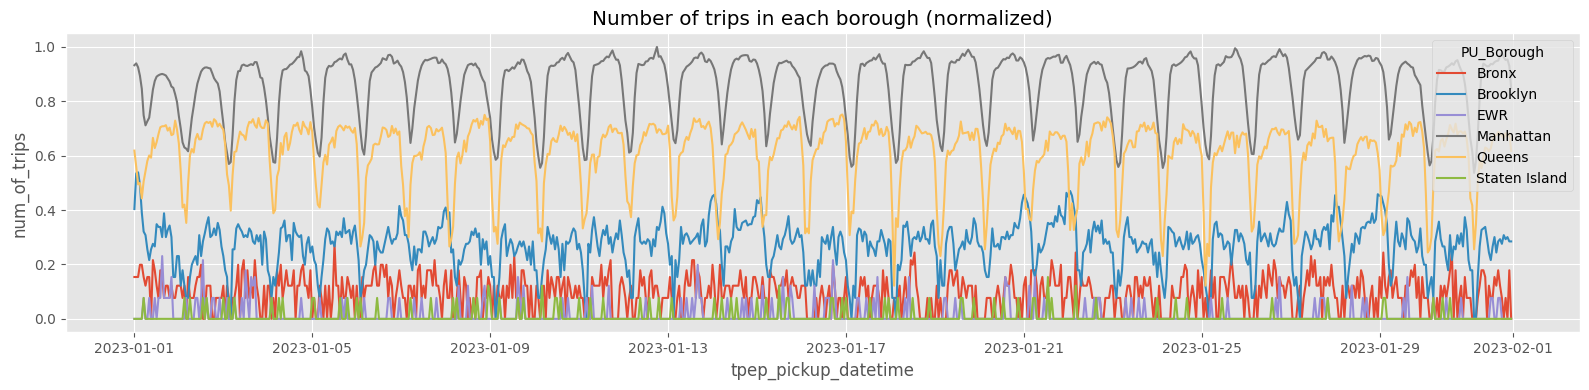

In [20]:
transformers = ColumnTransformer([
    ('pass', 'passthrough', ['tpep_pickup_datetime', 'PU_Borough']),
    ('min_max_scaling', MinMaxScaler(), ['num_of_trips']),
], verbose_feature_names_out=False)
transformers.set_output(transform='pandas')

pipe = Pipeline([
    ('transformers', transformers)
])


fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.lineplot(pipe.fit_transform(df_grouped), x='tpep_pickup_datetime', y='num_of_trips', hue='PU_Borough', ax=ax)
ax.set_title('Number of trips in each borough (normalized)')
fig.tight_layout()

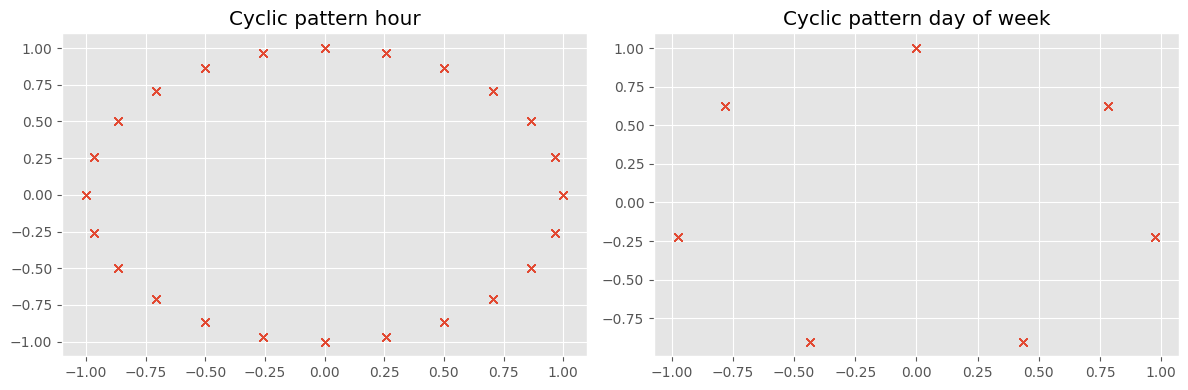

In [21]:
fig, ax = plt.subplots(1, 2,  figsize=(12, 4))
ax[0].plot(df_grouped['sin_hour'], df_grouped['cos_hour'], 'x'), ax[1].plot(df_grouped['sin_day_of_week'], df_grouped['cos_day_of_week'], 'x')
ax[0].set_title('Cyclic pattern hour'), ax[1].set_title('Cyclic pattern day of week')
fig.tight_layout()

- Number of trips for other districs than Manhattan and Queens is almost always a zero value. Since the other areas are not the main operating areas of Yellow taxis (there are Green taxi area) I will for now drop them as it will break the predictive performance of models.
- Cyclic patterns work as expected

Also I have decided to perform a logarithmic transformation on target variable, as the effect of borogh on the number of trips seems multiplicative

I will utilize the following split to create separate training and testing datasets for modeling, based on the pickup date:

- Training dataset: It will consist of data from days 1 to 21.
- Testing dataset: It will include data from days 22 to 31.

In [25]:
df_grouped = (
    # limiting data to only two districts
    df_grouped[df_grouped['PU_Borough'].isin(['Manhattan', 'Queens'])]
    # recasting datatype (seaborn still shows old districts using pd.cat.categories)
    .astype({'PU_Borough': 'object'}).astype({'PU_Borough': 'category'})
    .reset_index(drop=True)
)

# split condition
condition = df_grouped['tpep_pickup_datetime'] < '2023-01-22'
df_train, df_test = df_grouped[condition], df_grouped[~condition]
display(df_train.head(4), df_test.head(4))

,tpep_pickup_datetime,PU_Borough,num_of_trips,hour,day_of_week,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week
0,2023-01-01 00:00:00,Manhattan,8.399535,0,6,0.000000,1.000000,-0.781831,0.62349
1,2023-01-01 00:00:00,Queens,5.572154,0,6,0.000000,1.000000,-0.781831,0.62349
2,2023-01-01 01:00:00,Manhattan,8.460199,1,6,0.258819,0.965926,-0.781831,0.62349
3,2023-01-01 01:00:00,Queens,5.036953,1,6,0.258819,0.965926,-0.781831,0.62349


,tpep_pickup_datetime,PU_Borough,num_of_trips,hour,day_of_week,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week
1008,2023-01-22 00:00:00,Manhattan,8.549660,0,6,0.000000,1.000000,-0.781831,0.62349
1009,2023-01-22 00:00:00,Queens,4.828314,0,6,0.000000,1.000000,-0.781831,0.62349
1010,2023-01-22 01:00:00,Manhattan,8.407378,1,6,0.258819,0.965926,-0.781831,0.62349
1011,2023-01-22 01:00:00,Queens,2.944439,1,6,0.258819,0.965926,-0.781831,0.62349


<Axes: xlabel='day_of_week', ylabel='num_of_trips'>

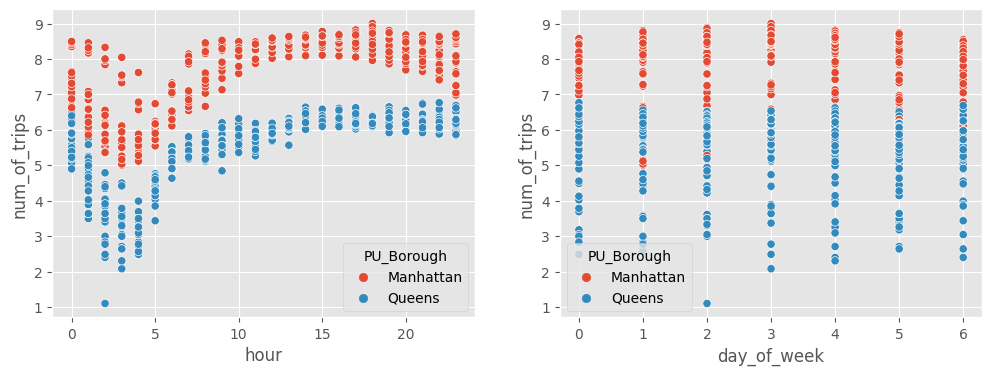

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax=ax.ravel()
sns.scatterplot(df_train,  x='hour', y='num_of_trips', hue='PU_Borough', ax=ax[0])
sns.scatterplot(df_train,  x='day_of_week', y='num_of_trips', hue='PU_Borough', ax=ax[1])

<Axes: xlabel='num_of_trips', ylabel='Count'>

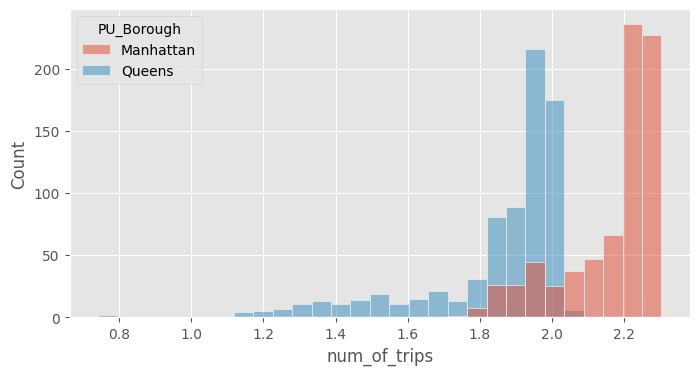

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(x=np.log(df_grouped['num_of_trips'] + 1), hue=df_grouped['PU_Borough'])

# Linear regression

In [28]:
transformers = ColumnTransformer([
    # onehot encoding borough
    ('encode_borough', OneHotEncoder(sparse_output=False), ['PU_Borough']),
    # normalizing target variable to 0 to 1 scale
    ('normalize_target', MinMaxScaler(), ['num_of_trips']),
    # no need to process sin/cos features as they are on -1 to 1 scale
    ('pass', 'passthrough', ['sin_hour', 'cos_hour', 'sin_day_of_week', 'cos_day_of_week']),
], verbose_feature_names_out=False)
transformers.set_output(transform='pandas')

data_processing_pipe = Pipeline([
    ('transformers', transformers),
])

df_train_processed = data_processing_pipe.fit_transform(df_train)
X_features = [i for i in df_train_processed.columns if i != 'num_of_trips']
target = ['num_of_trips']
X_train, y_train = df_train_processed[X_features], df_train_processed[target]
df_test_processed = data_processing_pipe.transform(df_test)
X_test, y_test = df_test_processed[X_features], df_test_processed[target]

In [29]:
models = [
    ('lr_l2', Ridge(), {
        'alpha': np.linspace(0, 10, 20)
    }),
    ('tree_regressor', DecisionTreeRegressor(random_state=789), {
        'max_depth': [1, 2, 5, 10, 20, 30, None],
        'min_samples_split': np.linspace(2, 11, dtype=np.int8),
        'min_samples_leaf': np.linspace(1, 11, dtype=np.int8),
        # 'min_impurity_decrease': np.linspace(0, 11, dtype=np.float16),
        # 'ccp_alpha': np.linspace(0, 11, dtype=np.float16),
    }),
]
trained_models = {}

for model_name, model, param_grid in models:
    cv = RandomizedSearchCV(model, param_grid, n_iter=20, scoring='neg_mean_squared_error', n_jobs=4, cv=5, random_state=888).fit(X_train, y_train)
    trained_models[model_name] = clone(cv.best_estimator_).fit(X_train, y_train)
    print(f'Model: {model_name},\tBest model score: {round(cv.best_score_, 3)},\tBest model parameters: {cv.best_params_}')

Model: lr_l2,	Best model score: -0.007,	Best model parameters: {'alpha': 1.5789473684210527}
Model: tree_regressor,	Best model score: -0.002,	Best model parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}


## Inspecting model prediction

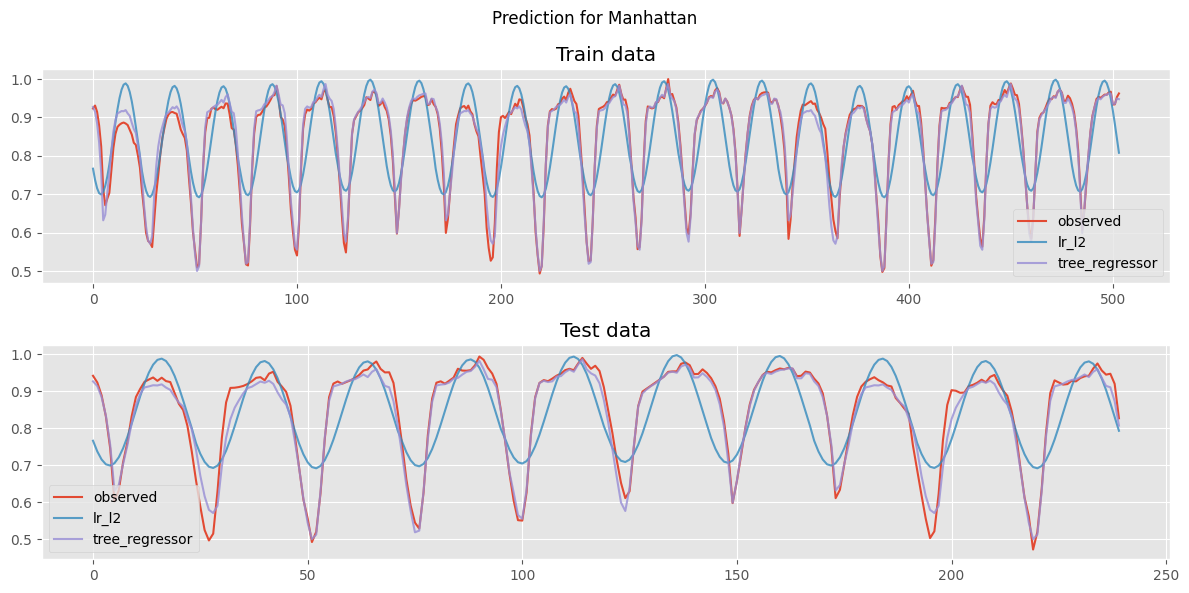

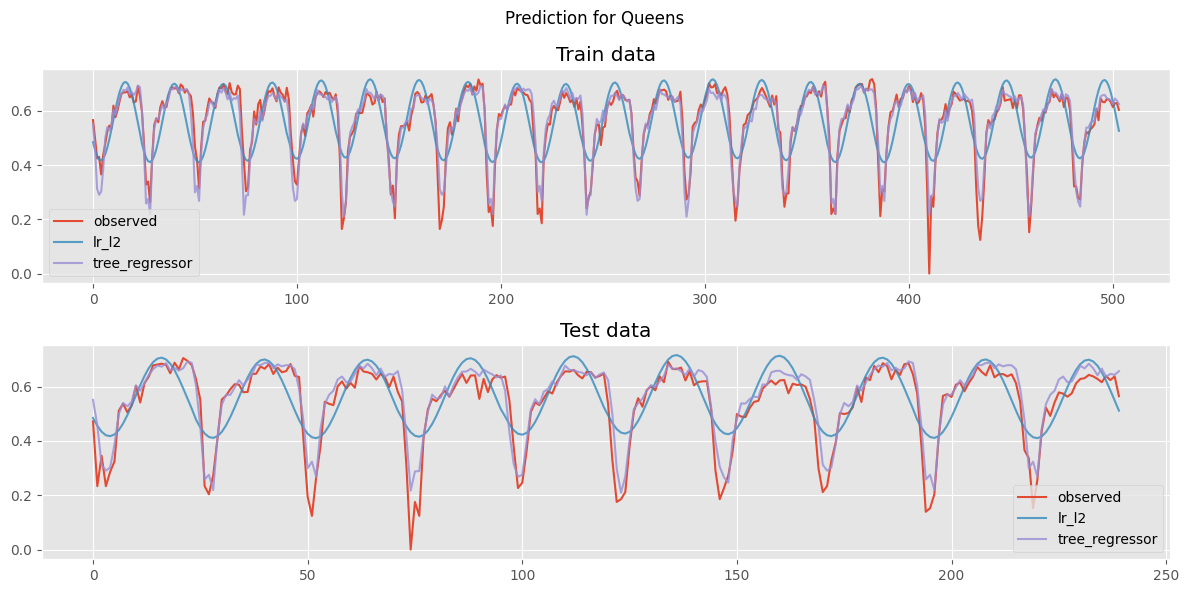

In [30]:
def plot_for_borough(borough):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    for idx, data in enumerate([df_train, df_test]):
        # dataset fragment on Manhattan data
        data_borough = data_processing_pipe.transform(data[data['PU_Borough'] == borough])
        y_true = data_borough[target].reset_index(drop=True)

        ax[idx].plot(y_true)
        for key in trained_models.keys():
            y_prediction = trained_models[key].predict(data_borough[X_features])
            ax[idx].plot(y_prediction, alpha=.8)

        ax[idx].legend(['observed', *trained_models.keys()])

    ax[0].set_title('Train data'), ax[1].set_title('Test data'), 
    fig.suptitle(f'Prediction for {borough}')
    fig.tight_layout()

plot_for_borough('Manhattan')
plot_for_borough('Queens')

Using simple tree regressor work quiet well for both boroghs, linear model definetly fails in both cases, I guess this type of model in simple linear fashion would also require the interaction term, but I want to also test full categorical encdoing of data

## Linear full categorical encoding

In [31]:
transformers = ColumnTransformer([
    # onehot encoding borough
    ('encode_borough', OneHotEncoder(sparse_output=False), ['PU_Borough', 'hour', 'day_of_week']),
    # normalizing target variable to 0 to 1 scale
    ('normalize_target', MinMaxScaler(), ['num_of_trips']),
], verbose_feature_names_out=False)
transformers.set_output(transform='pandas')

data_processing_pipe = Pipeline([
    ('transformers', transformers),
])

df_train_processed = data_processing_pipe.fit_transform(df_train)
X_features = [i for i in df_train_processed.columns if i != 'num_of_trips']
target = ['num_of_trips']
X_train, y_train = df_train_processed[X_features], df_train_processed[target]
df_test_processed = data_processing_pipe.transform(df_test)
X_test, y_test = df_test_processed[X_features], df_test_processed[target]

In [32]:
models = [
    ('lr_l2', Ridge(), {
        'alpha': np.linspace(0, 10, 20)
    }),
    ('tree_regressor', DecisionTreeRegressor(random_state=789), {
        'max_depth': [1, 2, 5, 10, 20, 30, None],
        'min_samples_split': np.linspace(2, 11, dtype=np.int8),
        'min_samples_leaf': np.linspace(1, 11, dtype=np.int8),
        # 'min_impurity_decrease': np.linspace(0, 11, dtype=np.float16),
        # 'ccp_alpha': np.linspace(0, 11, dtype=np.float16),
    }),
]
trained_models = {}

for model_name, model, param_grid in models:
    cv = RandomizedSearchCV(model, param_grid, n_iter=20, scoring='neg_mean_squared_error', n_jobs=4, cv=5, random_state=888).fit(X_train, y_train)
    trained_models[model_name] = clone(cv.best_estimator_).fit(X_train, y_train)
    print(f'Model: {model_name},\tBest model score: {round(cv.best_score_, 3)},\tBest model parameters: {cv.best_params_}')

Model: lr_l2,	Best model score: -0.004,	Best model parameters: {'alpha': 0.5263157894736842}
Model: tree_regressor,	Best model score: -0.002,	Best model parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30}


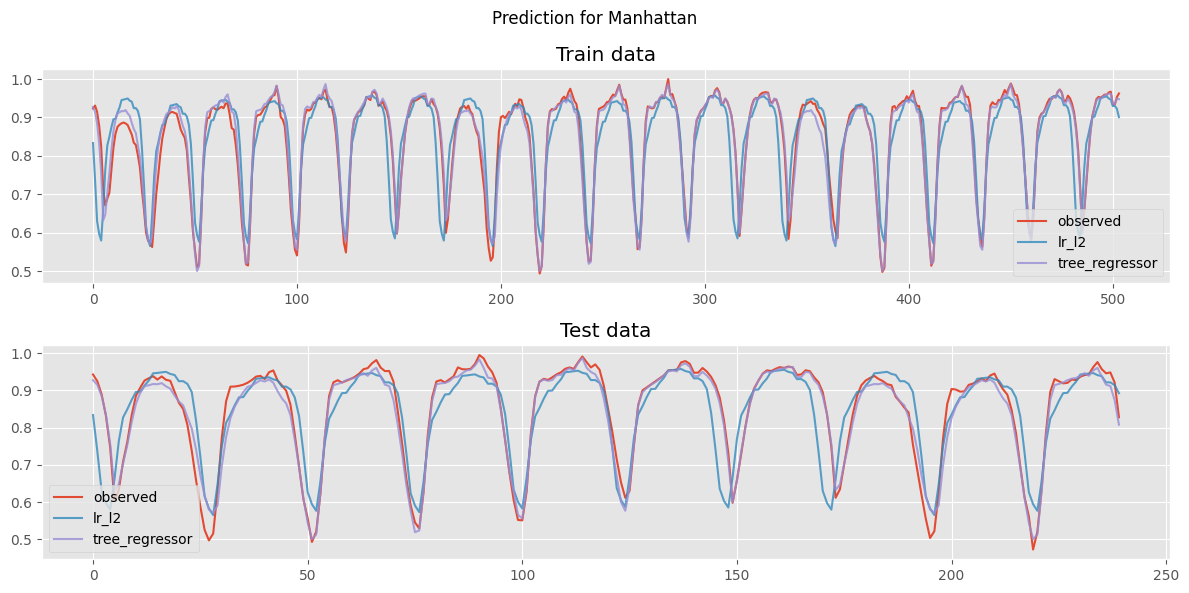

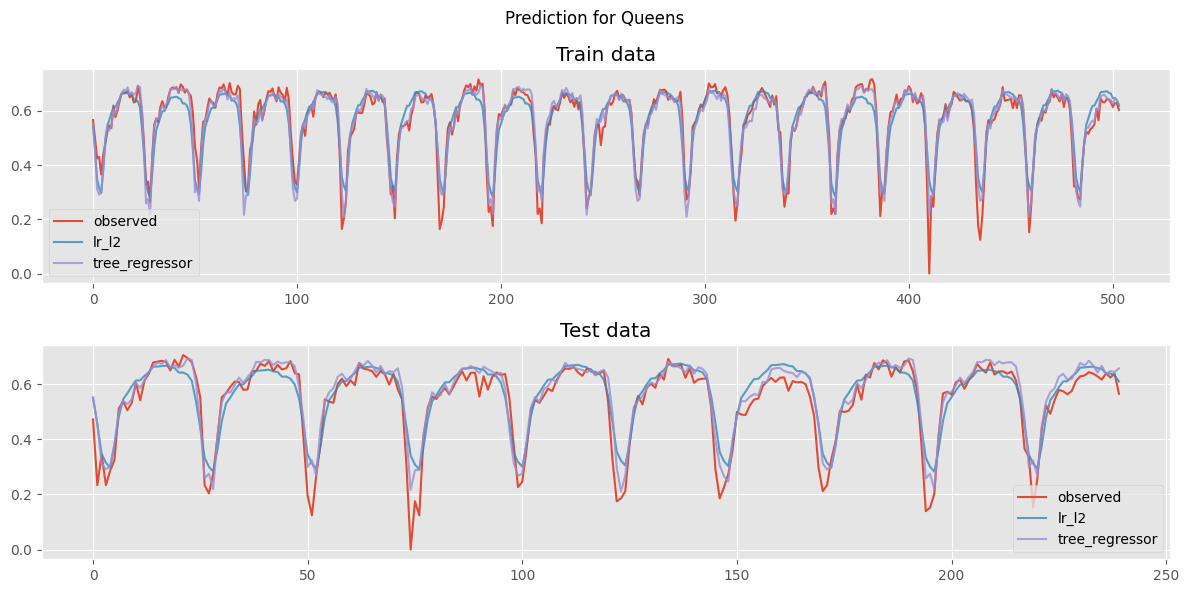

In [33]:
plot_for_borough('Manhattan')
plot_for_borough('Queens')

So this kind of works, it gets the general trend happening in both boroghs, but its not great.